# Solution - Polynomial Regression

<img src="https://i.pinimg.com/originals/52/2c/20/522c209c019fe9592857bcb569184478.jpg">

## Goals

After completing this notebook, you will be able to:
1. Generate data for a polynomial regression
2. Construct a set of polnomial regression models usings `scikit-learn`
3. Explain why we want to split data for modeling/evaluation
4. Evaluate the quality of fit for a set of models using adjusted $R^2$ and by comparing true and predicted values
4. Explain why that model is the best fit for this data

## Our Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import pandas as pd

from IPython.display import HTML

from sklearn.model_selection import train_test_split ## Used for automatically splitting data
from sklearn.linear_model import LinearRegression    ## One of many kinds of regression models

%matplotlib inline

ModuleNotFoundError: No module named 'sklearn'

---
## 1. Polynomial Regression

To understand and model the underlying relationships between variables in data, we can create **regression models** to "fit" the data. The simplest regression model (that you've probably seen before) is linear regression with a first order polynomial, where the relationship between two variables is fit with a straight line: $Ax + B$. 

It's possible that a straight line is not going to be good enough to model the data we are working with. We can augment our $ Ax + B$ with extra features. By adding features we are still doing linear regression, but we the features themselves can consist of, well anything.

However, to be focused, we will use polynomials. We can add values like $x^2$ or $x^5$ to the potential set of features that can be used to better map against our data. 

<font size=8 color="#009600">&#9998;</font> Do This -  The question is, how many such features should we add? What are the advantages and disadvantages of adding more and more features? Think about it and answer in the cell below.

<font size=8 color="#009600">&#9998;</font> Answer here

### 1.1 Let's make some Data

It's always good when we are starting out to generate our own data. Data we generate gives us the advantage of **knowing** what the answer should be. 

<font size=8 color="#009600">&#9998;</font> Do This -  Let's do the following:
* build a numpy array `x_ary` of values from -4 to 4 with a step size of 0.02
* generate a corresponding `y_ary`, using the values from `x_ary`, based on the formula $x^4 + 2x^3 -15x^2 -12x + 36$
* create `y_noisy`, by adding random (Gaussian) noise to `y_ary` in the range of -15 to 15. Later on we might make the range bigger (say -25 to 25) or smaller (say -5 to 5) for comparison. You will want to use `np.random.normal(avg, std_dev, N)` to do so.

In [3]:
# your code here

In [4]:
### ANSWER ###

x_ary = np.arange(-4,4,0.02)
y_ary = x_ary**4 + 2*x_ary**3 - 15*x_ary**2 - 12*x_ary + 36

mu = 0
sigma = 15

random_noise  = np.random.normal(mu, sigma, len(x_ary))
    
y_noisy = y_ary + random_noise

### 1.2 Plot the data

We should really look at our data before we try to model it.

<font size=8 color="#009600">&#9998;</font> Do This -  plot `x_ary` vs both `y_ary` and `y_noisy`. Do it overlapping with colors, or side by side, whatever you think would look good. _Make sure to label your axes!_ Consider adding a legend by using: `plt.legend(['Plot 1', 'Plot 2'])`.

In [5]:
# your code here

Text(0, 0.5, 'y')

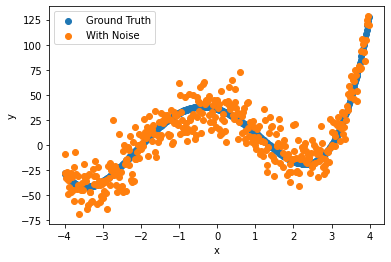

In [6]:
### ANSWER ###

plt.scatter(x_ary, y_ary)
plt.scatter(x_ary,y_noisy)
plt.legend(['Ground Truth', 'With Noise'])
plt.xlabel('x')
plt.ylabel('y')

---
## 2 Making the Polynomial Features

Ultimately it would be nice to do our work using a `pandas` DataFrame so that we have the opportunity to label our columns. There's the added benefit that `scikit-learn` just works with `pandas` DataFrames. 

<font size=8 color="#009600">&#9998;</font> Do This - Make a DataFrame consisting of the following columns: a constant value for the intercept, the values in `x_ary`, and additional powers of `x_ary` up to 10.

You can do this one of two ways:
1. make the DataFrame out of `x_ary` and add features to the DataFrame
2. add columns to the `x_ary` array and then finish off by adding to a DataFrame

In the end, you have a DataFrame no matter the approach.

As a reminder, the columns of the DataFrame should be:
* Label the first column "const" and just place the value 1 in it
* make the `x_ary` data column 1, labeled "data"
* the next 9 columns should be based on `x_ary` and have as values: $x^2$, $x^3$, $x^4 \ldots$ $x^{10}$. Give them good (but short) label names

Print the head of your DataFrame when you're done.

In [7]:
# your code

In [8]:
### ANSWER ###

const = np.ones(len(x_ary))

df = pd.DataFrame(const, columns=['const'])

df['data'] = x_ary

for i in range(2,11):
    
    label = "x" + str(i)
    
    df[label] = x_ary**i
    
df.head()

,const,data,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,1.0,-4.00,16.0000,-64.000000,256.000000,-1024.000000,4096.000000,-16384.000000,65536.000000,-262144.000000,1.048576e+06
1,1.0,-3.98,15.8404,-63.044792,250.918272,-998.654723,3974.645798,-15819.090277,62959.979304,-250580.717629,9.973113e+05
2,1.0,-3.96,15.6816,-62.099136,245.912579,-973.813811,3856.302692,-15270.958660,60472.996294,-239473.065324,9.483133e+05
3,1.0,-3.94,15.5236,-61.162984,240.982157,-949.469698,3740.910612,-14739.187810,58072.399973,-228805.255894,9.014927e+05
4,1.0,-3.92,15.3664,-60.236288,236.126249,-925.614896,3628.410392,-14223.368737,55755.605448,-218561.973356,8.567629e+05


### 2.1 Train-test splitting

One of the critical aspects of machine learning is worrying about overfitting or underfitting your data. This is essential to machine learning as we can never avoid the Bias-Variance tradeoff ([Great Conceptual Video on this](https://www.youtube.com/watch?v=EuBBz3bI-aA)).

* **Overfitting** - when your model captures too many aspects of what it learns from so that it fits the data it learned from really well. Results: A really good fit for learned data, but not a great fit for new data from the same phenomenon.
* **Underfitting** - when your model captures too few aspects of what it learns from so that it fits data it learned from poorly. Results: A poor model fit for learned data, and probably also a poor fit for new data.

One of the ways we deal with this tradeoff and problems with fit is to split the original data into a `training` and `test` set. Effectively, we build the model using the `training` data. And we evaluate the quality of the fit using the `test` data. Note that this is a totally different paradigm from statistical explanatory models that use the whole data set. There's a great discussion of this two paradigms by Galit Shmueli ([To Explain or To Predict?](https://www.stat.berkeley.edu/~aldous/157/Papers/shmueli.pdf)).

In any event, we introduce `train_test_split()`, which is built into the `scikit-learn` toolkit, to split our data and conduct our analysis. 

For this case, we can simple use the call: `X_train, X_test, y_train, y_test = train_test_split(df, y_noisy, test_size=0.2)` where `df` is the name of your data frame. Then each returned variable represents the training and testing set inputs and outputs respectively.

<font size=8 color="#009600">&#9998;</font> Do This - Split your data with 20% going to test data and 80% to training (this is a common split ratio in ML). Print the length of the resulting arrays to confirm the split occured as you planned.

In [9]:
## your code here

In [10]:
### ANSWER ###

X_train, X_test, y_train, y_test = train_test_split(df, y_noisy, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_test))

320
80


### 2.2 Fitting using the Polynomials

We'll talk about measures of "goodness" of fit in more detail on day 4, but one good measure for a multi-feature fit is the **Adjusted R-squared** value. In general, the **R-squared** describes the variance in the model that it can account for. If the R-squared is 1.0, then all the variance is accounted for an you have a perfect fit. If the value is 0 and you have no fit. However, for multiple features R-squared tends to over-estimate. The Adjusted R-squared tries to deal with this and provide a value that is better suited to multiple features.

We'll leave it to you how you want to do this, but what we'd like you to try is to fit different combinations of features against `y_noisy` and report the Adjusted R-squared value. For example, what is the Adj-r-squared for:

1. just the const column
2. the const and data column (which should be a line)
3. the const, data and $x^2$ column
4. the const, data, $x^2$ and $x^3$ column
5. $\ldots$

So on and so forth. You can do them individually or on a loop and collect the results. 

A piece of code that can help with regression results for scikit-learn is below:

```python
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
```

If you want to use this function, you need to include it in a cell and execute it. Then you can call it later using: `regression_results(y_true, y_pred)`.

All of these metrics are available for regression models with `scikit-learn`, which is really useful as you can swap out models without changing how you do your evaluation! 

<font size=8 color="#009600">&#9998;</font> Do This - Create a variety of models that fit to the noisy data using increasingly more features recall you are fitting with the training set (`X_train` and `y_train`). Then use the model to predict the what the output should be (`y_pred`). Then compare the predicted value to the real value using `.r2_score`.  Look at that value for the combination of features you selected and say which one is the "best". For this work, we would consider the "best" would be the highest value of `.r2_score`.

To help here's some code:

```python
linear = LinearRegression()           ## Create the linear model
cols = ['const','data','x2','x3']     ## Select the columns for the model
linear.fit(X_train[cols],y_train)     ## Fit the model

y_pred = linear.predict(X_test[cols]) ## Test the model
regression_results(y_test, y_pred)    ## compare the results
```

This process is similar for every `scikit-learn` regression model.

In [11]:
# your code here

In [12]:
### ANSWER ###

import sklearn.metrics as metrics

X_train, X_test, y_train, y_test = train_test_split(df, y_noisy, test_size=0.2, random_state=42)

linear = LinearRegression()

for i in range(1,len(X_train.columns)+1):
    cols = X_train.columns[:i]

    linear.fit(X_train[cols],y_train)

    y_pred = linear.predict(X_test[cols])

    r2=metrics.r2_score(y_test, y_pred)

    print("x" + str(i-1), "r2 =", round(r2,4))

x0 r2 = -0.0029
x1 r2 = 0.383
x2 r2 = 0.3585
x3 r2 = 0.6245
x4 r2 = 0.8687
x5 r2 = 0.8681
x6 r2 = 0.867
x7 r2 = 0.8677
x8 r2 = 0.8668
x9 r2 = 0.8684
x10 r2 = 0.8689


In [18]:
### ANSWER ###

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4)) 
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

cols = ['const','data','x2','x3','x4']

linear.fit(X_train[cols],y_train)

y_pred = linear.predict(X_test[cols])

regression_results(y_test, y_pred)

explained_variance:  0.8694
r2:  0.8687
MAE:  12.0222
MSE:  219.0911
RMSE:  14.8017


<font size=8 color="#009600">&#9998;</font> Do This - Which combination of features best "fit" your data? What was the Adjusted R-squared? Why might that combination produce the best fit?

<font size=8 color="#009600">&#9998;</font> Answer here

---
## 3. Plot your data and your model

<font size=8 color="#009600">&#9998;</font> Do This -  Plot `x_ary` vs `y_noisy` and `x_ary` vs the best fitted values based on the adjusted rsquared value. Do it in the same graph. 

In [19]:
# your code here

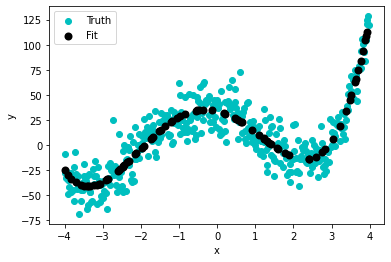

In [20]:
### ANSWER ###

plt.scatter(x_ary, y_noisy, color='c')
plt.scatter(X_test['data'], y_pred, color='k', lw=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Truth','Fit'])

### 3.1 Are we justified in using this model?

We can check how well we are justified in using this model, by comparing the actual and predicted values as well as making a residual plot.

* The first plot is plotting the predicted values against the real values. In a perfect model, they would form a line with a slope of 1.
* The second plot has a bit more information about the fit. Effectively, to be justfied in using a linear model, our residuals better be randomly disitrbuted. That's a qualifier for using linear regression. So here you must plot the `res = real - predicted` against x values. Here's a [short discussion on how that works](https://stattrek.com/regression/residual-analysis.aspx).

<font size=8 color="#009600">&#9998;</font> Do This - Make the two plots mentioned above. Make sure to plot the residuals as a function of the independent variable (`data` or `x`, whatever you called it).

In [21]:
## your code here

Text(0, 0.5, 'Residuals')

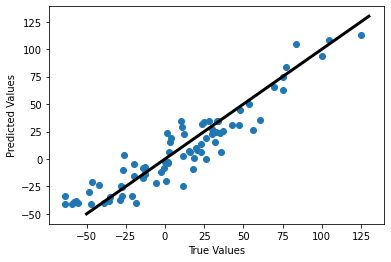

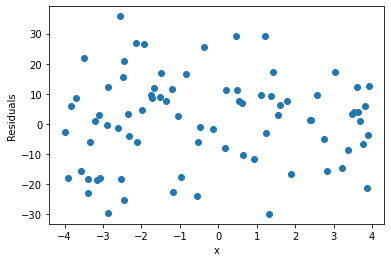

In [22]:
### ANSWER ###

plt.figure()
plt.scatter(y_test,y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([-50,130],[-50,130], color='k', lw=3)

res = y_test-y_pred

plt.figure()
plt.scatter(X_test['data'], res)
plt.xlabel('x')
plt.ylabel('Residuals')

<font size=8 color="#009600">&#9998;</font> Answer here - Do we appear justified in using this model? Why or why not? 